In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib
import sys
import os

project_path = os.path.abspath('..')
if project_path not in sys.path:
    sys.path.append(project_path)



from MieSppForce import frenel, dipoles, green_func, force

c_const = 299792458
eps0_const = 1/(4*np.pi*c_const**2)*1e7
mu0_const = 4*np.pi * 1e-7

In [2]:
eps_Au = frenel.get_interpolate('Au')
eps_Si = frenel.get_interpolate('Si')

R = 295/2
dist = 2
a_angle = 0
phase=0
STOP=45
angle=25*np.pi/180
point = [0,0,dist+R]

z0 = point[2]

wls=np.linspace(800,1100,100)

P,M = np.empty((len(wls),3), dtype=complex),np.empty((len(wls),3), dtype=complex)

F_x, F_y, F_z = np.empty((len(wls), 8)), np.empty((len(wls), 8)), np.empty((len(wls), 8))

In [3]:
for i in tqdm(range(len(wls))):
    p,m = dipoles.calc_dipoles_v2(wls[i], eps_Au, point, R, eps_Si, angle, amplitude=1, phase=phase, a_angle=a_angle, stop=STOP)
    p,m = p[:,0],m[:,0]
    P[i,:],M[i,:]=p,m
    
    f = force.F(wls[i], eps_Au, point, R, eps_Si, angle, 1, phase, a_angle, STOP, True)
    
    F_x[i,:] = f[0]
    F_y[i,:] = f[1]
    F_z[i,:] = f[2]

  7%|▋         | 7/100 [00:18<03:59,  2.57s/it]c:\Users\borod\Desktop\SPP_ANALYTICAL\SPP_ANALYTICAL\.venv\Lib\site-packages\scipy\integrate\_quadpack_py.py:441: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  re_retval = quad(refunc, a, b, args, full_output, epsabs,
 87%|████████▋ | 87/100 [03:47<00:35,  2.70s/it]c:\Users\borod\Desktop\SPP_ANALYTICAL\SPP_ANALYTICAL\.venv\Lib\site-packages\scipy\integrate\_quadpack_py.py:444: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  im_retval = quad(imfunc, a, b, args, full_output, epsabs,
100%|██████████| 100/100 [04:22<00:00,  2.62s/it]


In [4]:
dipoles_tm_3d_currents = np.loadtxt('p_m_tm_comsol_3d_current.txt', skiprows=8, delimiter=',')
dipoles_tm_3d = np.loadtxt('p_m_tm_comsol_3d.txt', skiprows=8, delimiter=',')
dipoles_tm_2d = np.loadtxt('p_m_tm_comsol_2d.txt', skiprows=8, delimiter=',')

wls_2d = dipoles_tm_2d[:,0]
px_2d = dipoles_tm_2d[:,1]-1j*dipoles_tm_2d[:,2]
my_2d = dipoles_tm_2d[:,3]-1j*dipoles_tm_2d[:,4]
pz_2d = dipoles_tm_2d[:,5]-1j*dipoles_tm_2d[:,6]

wls_3d = dipoles_tm_3d[:,0]
px_3d = dipoles_tm_3d[:,1]-1j*dipoles_tm_3d[:,2]
my_3d = dipoles_tm_3d[:,3]-1j*dipoles_tm_3d[:,4]
pz_3d = dipoles_tm_3d[:,5]-1j*dipoles_tm_3d[:,6]

wls_3d_c = dipoles_tm_3d_currents[:,0]
px_3d_c = dipoles_tm_3d_currents[:,1]-1j*dipoles_tm_3d_currents[:,2]
my_3d_c = dipoles_tm_3d_currents[:,3]-1j*dipoles_tm_3d_currents[:,4]
pz_3d_c = dipoles_tm_3d_currents[:,5]-1j*dipoles_tm_3d_currents[:,6]

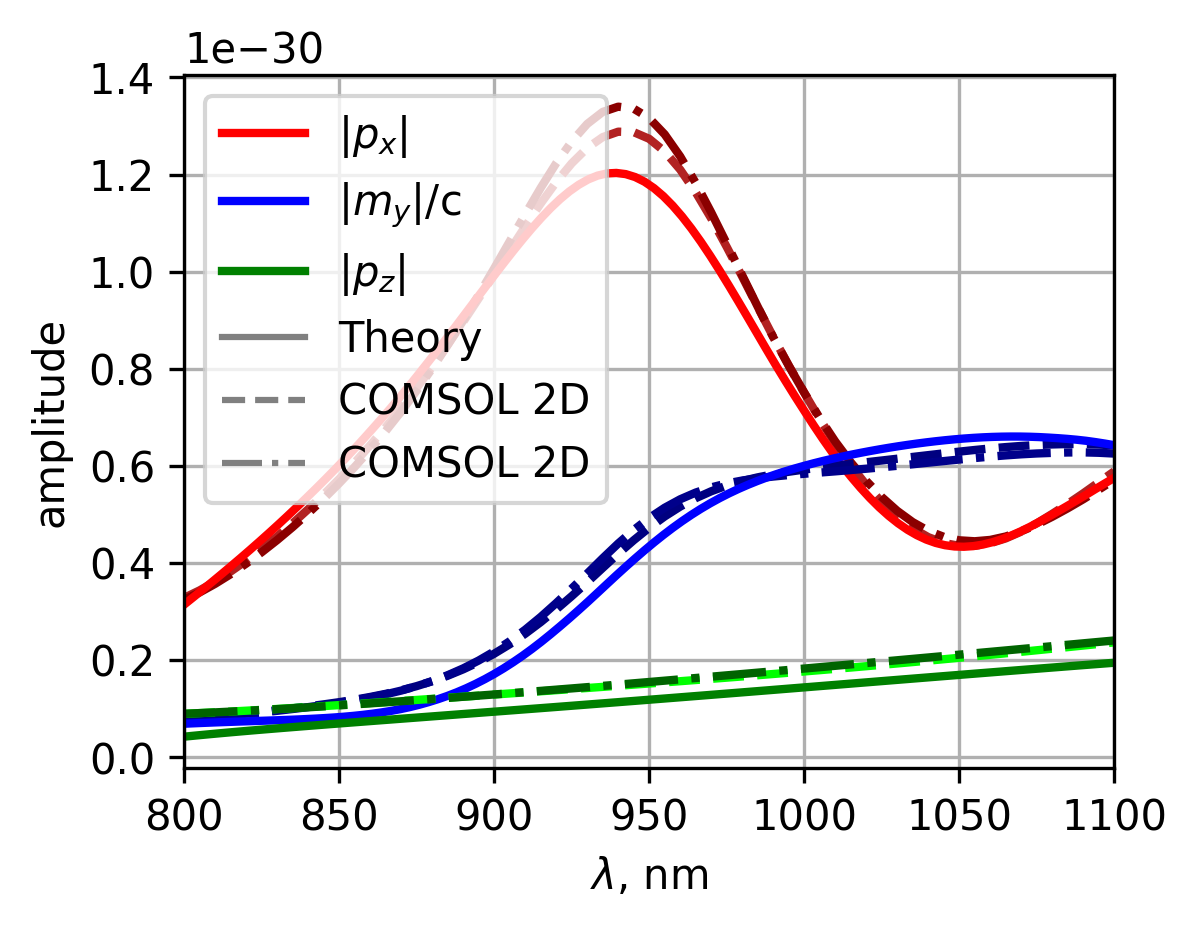

In [7]:
plt.figure(figsize=(4,3), dpi=300)

plt.plot(wls_2d, np.abs(px_2d), ls='--', c='firebrick', lw=2)
plt.plot(wls_3d, np.abs(px_3d), ls='-.', c='darkred', lw=2)
plt.plot(wls, np.abs(P[:,0]), label='|$p_x$|', c='r', lw=2)


plt.plot(wls_2d, np.abs(my_2d)/c_const, c='navy', lw=2, ls='--')
plt.plot(wls_3d, np.abs(my_3d/c_const), c='darkblue', lw=2, ls='-.')
plt.plot(wls, np.abs(M[:,1])/c_const, label='|$m_y$|/c',  c='b', lw=2)


plt.plot(wls_2d, np.abs(pz_2d), c='lime', lw=2, ls='--')
plt.plot(wls_3d, np.abs(pz_3d), c='darkgreen', lw=2, ls='-.')
plt.plot(wls, np.abs(P[:,2]), label='|$p_z$|',  c='g', lw=2)

plt.plot([], [], label="Theory",ls='-', c='grey')
plt.plot([], [], label="COMSOL 2D", ls='--', c='grey')
plt.plot([], [], label="COMSOL 2D",ls='-.', c='grey')

plt.legend()
plt.grid()
plt.xlim(wls[0], wls[-1])
plt.xlabel('$\\lambda$, nm')
plt.ylabel('amplitude')
plt.savefig('dip_ampl.pdf', bbox_inches='tight')
plt.show()

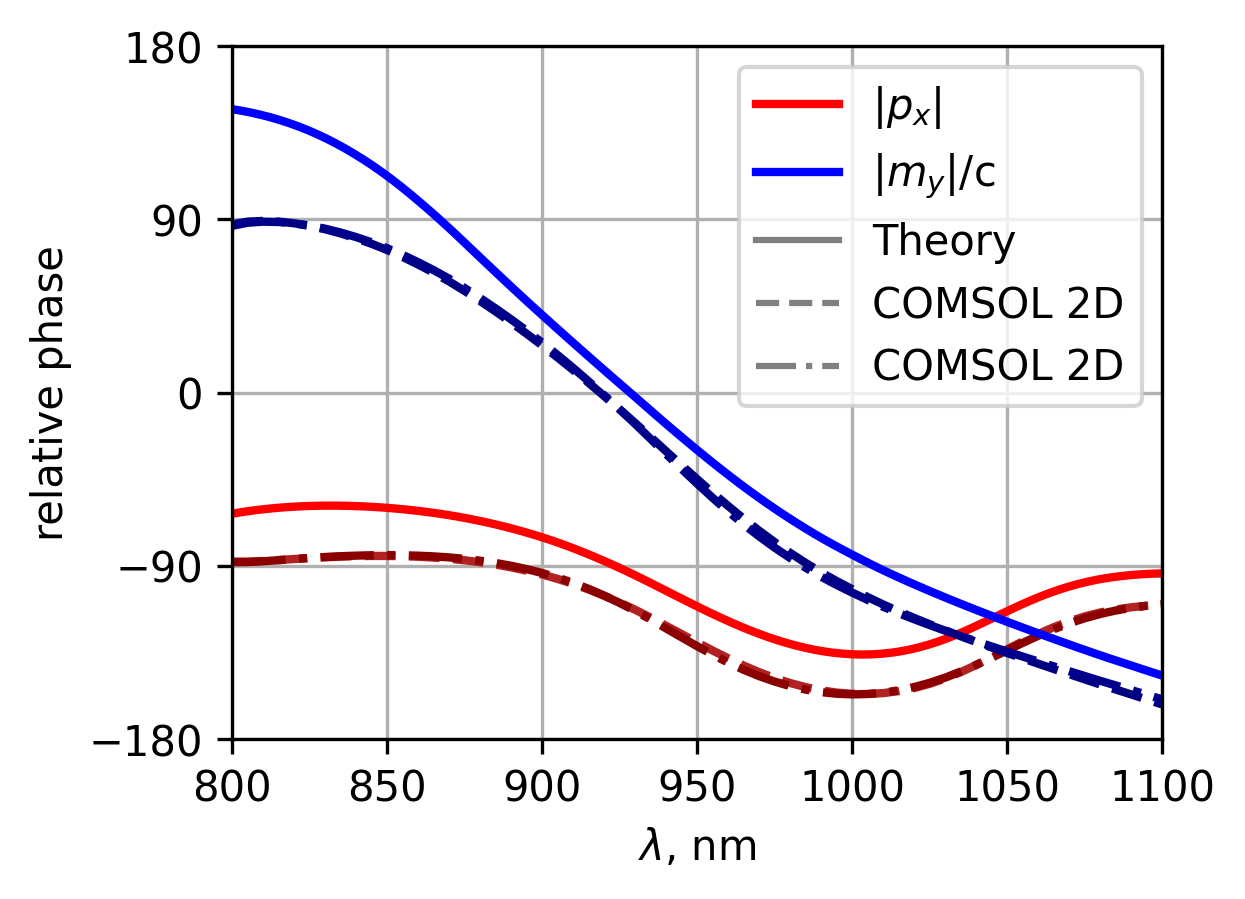

In [8]:
plt.figure(figsize=(4,3), dpi=300)

plt.plot(wls_2d, np.rad2deg(np.angle(px_2d/pz_2d)), ls='--', c='firebrick', lw=2)
plt.plot(wls_3d, np.rad2deg(np.angle(px_3d/pz_3d)), ls='-.', c='darkred', lw=2)
plt.plot(wls, np.rad2deg(np.angle(P[:,0]/P[:,2])), label='|$p_x$|', c='r', lw=2)


plt.plot(wls_2d, np.rad2deg(np.angle(my_2d/pz_2d/c_const)), c='navy', lw=2, ls='--')
plt.plot(wls_3d, np.rad2deg(np.angle(my_3d/pz_3d/c_const)), c='darkblue', lw=2, ls='-.')
plt.plot(wls, np.rad2deg(np.angle(M[:,1]/c_const/P[:,2])), label='|$m_y$|/c',  c='b', lw=2)


plt.plot([], [], label="Theory",ls='-', c='grey')
plt.plot([], [], label="COMSOL 2D", ls='--', c='grey')
plt.plot([], [], label="COMSOL 2D",ls='-.', c='grey')

plt.legend()
plt.grid()
plt.xlim(wls[0], wls[-1])
plt.xlabel('$\\lambda$, nm')
plt.ylim(-180,180)
plt.ylabel('relative phase')
plt.yticks(np.arange(-180,181,90))
plt.savefig('dip_phase.pdf', bbox_inches='tight')
plt.show()

In [9]:
from MieSppForce import  fields

z = 0
phi = np.linspace(0,2*np.pi, 100)
r = 2000
ERPHI = np.empty((len(wls), len(phi), 3), dtype=complex)
HRPHI = np.empty((len(wls), len(phi), 3), dtype=complex)


for i in range(len(wls)):
    for j in range(len(phi)):
        E,H = fields.get_field(wls[i], eps_Au, angle, phase, a_angle, STOP, eps_Si, R, r, phi[j], z, z0)
        ERPHI[i,j,:] = E
        HRPHI[i,j,:] = H

c:\Users\borod\Desktop\SPP_ANALYTICAL\SPP_ANALYTICAL\.venv\Lib\site-packages\scipy\integrate\_quadpack_py.py:444: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  im_retval = quad(imfunc, a, b, args, full_output, epsabs,
c:\Users\borod\Desktop\SPP_ANALYTICAL\SPP_ANALYTICAL\.venv\Lib\site-packages\scipy\integrate\_quadpack_py.py:441: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can 

<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\l'
C:\Users\borod\AppData\Local\Temp\ipykernel_13876\1186883164.py:6: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title(f"$|H_\\varphi|^2$ norm, $\lambda$ = {int(wls[wl_ind])}")


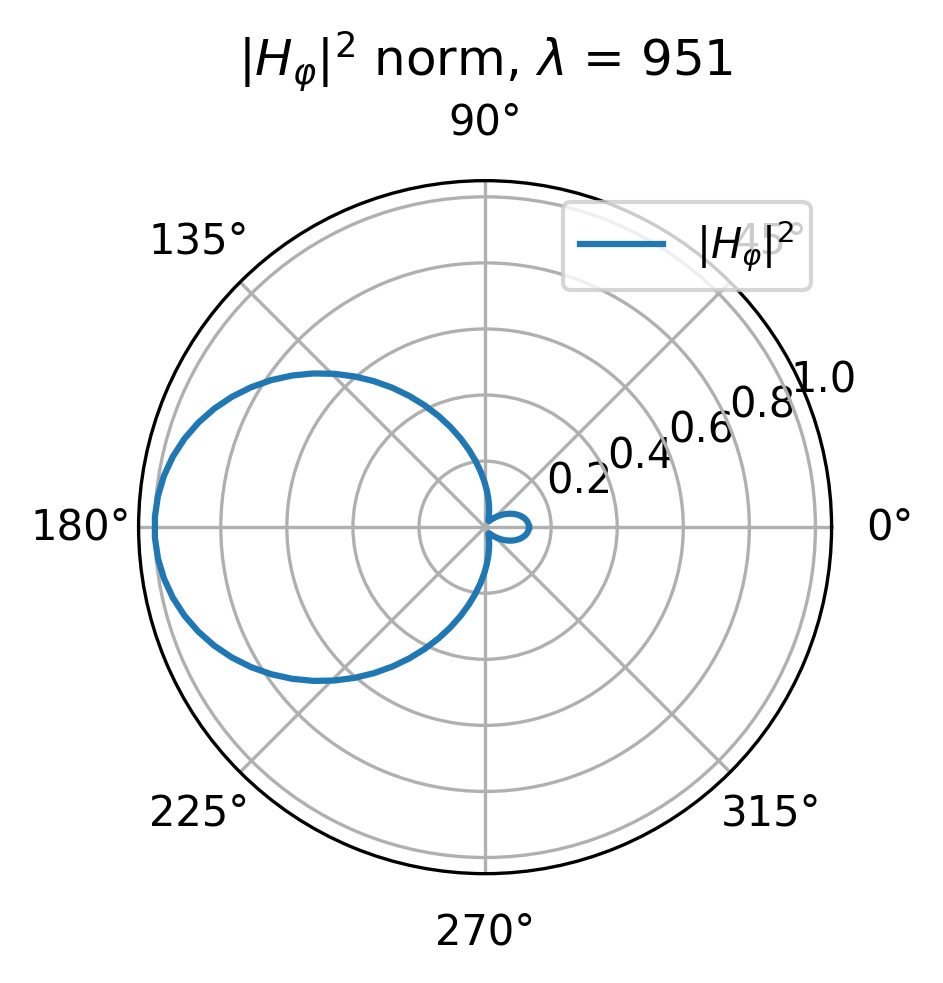

In [119]:
wl_ind=50

plt.figure(figsize=(3, 3), dpi=300)
ax = plt.subplot(111, polar=True)
ax.plot(phi, np.abs( -np.sin(phi)*HRPHI[wl_ind,:,0] + np.cos(phi)*HRPHI[wl_ind,:,1] )**2/np.max(np.abs( -np.sin(phi)*HRPHI[wl_ind,:,0] + np.cos(phi)*HRPHI[wl_ind,:,1] )**2), label='$|H_\\varphi|^2$')
ax.set_title(f"$|H_\\varphi|^2$ norm, $\lambda$ = {int(wls[wl_ind])}")
plt.legend()
plt.show()

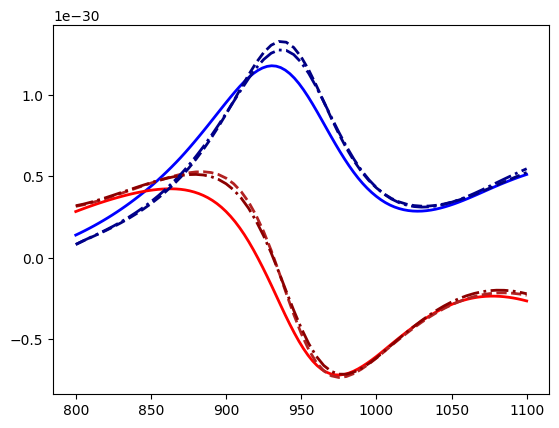

In [35]:

plt.plot( wls, P[:,0].real, label='Re(z)', lw=2, c='b') 
plt.plot( wls, P[:,0].imag, label='Im(z)', lw=2, c='r' )

plt.plot( wls_3d, px_3d.real, lw=2, ls='--', c='navy') 
plt.plot( wls_3d, px_3d.imag, lw=2, ls='--', c='firebrick') 

plt.plot( wls_2d, px_2d.real, lw=2, ls='-.', c='darkblue') 
plt.plot( wls_2d, px_2d.imag, lw=2, ls='-.', c='darkred') 


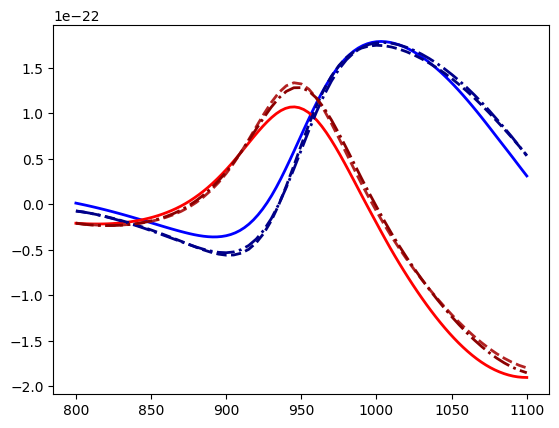

In [36]:

plt.plot( wls, M[:,1].real, label='Re(z)', lw=2, c='b') 
plt.plot( wls, M[:,1].imag, label='Im(z)', lw=2, c='r' )

plt.plot( wls_3d, my_3d.real, lw=2, ls='--', c='navy') 
plt.plot( wls_3d, my_3d.imag, lw=2, ls='--', c='firebrick') 

plt.plot( wls_2d, my_2d.real, lw=2, ls='-.', c='darkblue') 
plt.plot( wls_2d, my_2d.imag, lw=2, ls='-.', c='darkred') 


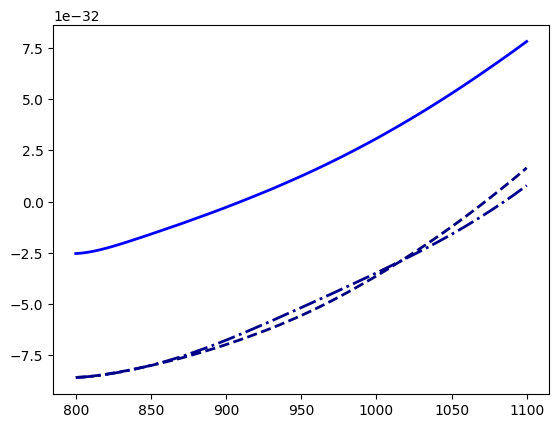

In [57]:

plt.plot( wls, P[:,2].real, label='Re(z)', lw=2, c='b') 
#plt.plot( wls, P[:,2].imag, label='Im(z)', lw=2, c='r' )

plt.plot( wls_3d, pz_3d.real, lw=2, ls='--', c='navy') 
#plt.plot( wls_3d, pz_3d.imag, lw=2, ls='--', c='firebrick') 

plt.plot( wls_2d, pz_2d.real, lw=2, ls='-.', c='darkblue') 
#plt.plot( wls_2d, pz_2d.imag, lw=2, ls='-.', c='darkred') 


In [58]:
zetta_2d= np.loadtxt('zetta_2d.txt', skiprows=8, delimiter=',')
zetta_3d= np.loadtxt('zetta_3d.txt', skiprows=8, delimiter=',')

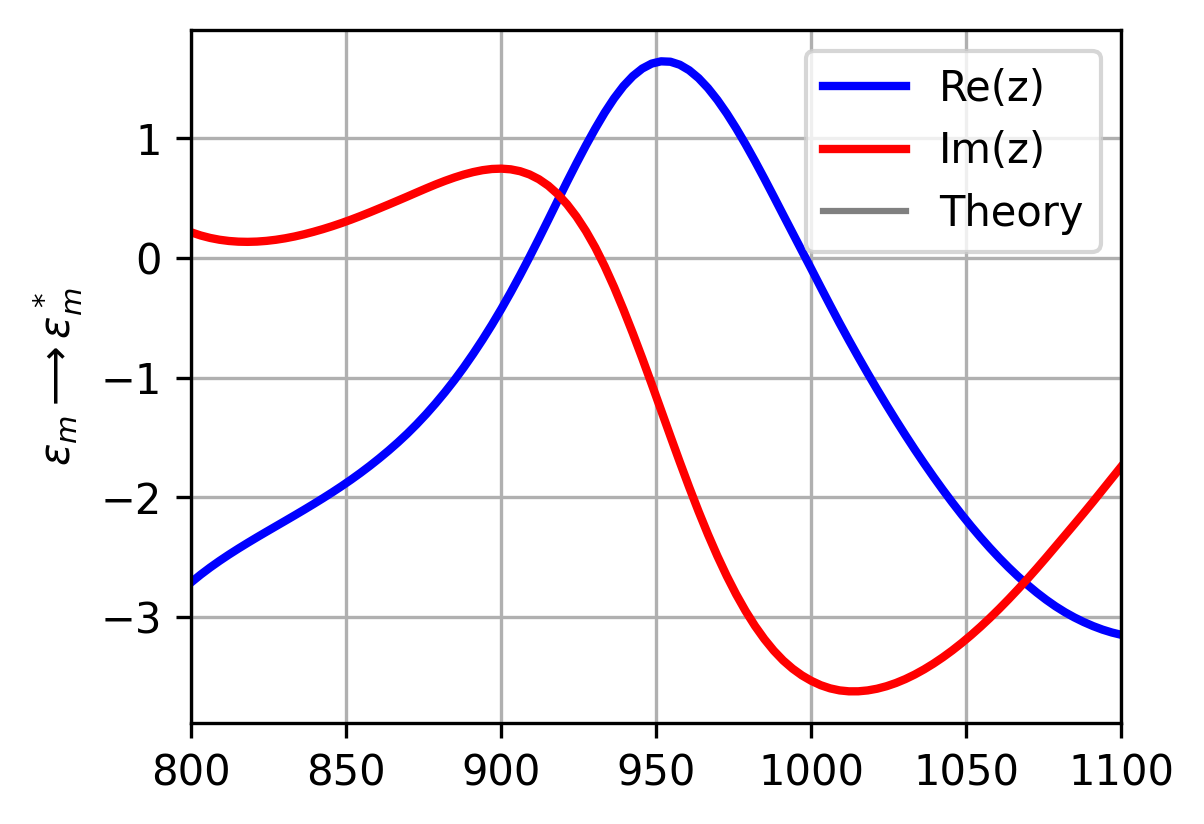

In [68]:
plt.figure( figsize=(4,3), dpi=300)
zetta_th = (M[:,1]/c_const - np.sqrt(1/(eps_Au(wls).conj()+1)) * P[:,0]) / (P[:,2] * np.sqrt(eps_Au(wls).conj()/(eps_Au(wls).conj() +1))) 

plt.plot( wls, zetta_th.real, label='Re(z)', lw=2, c='b') 
plt.plot( wls, zetta_th.imag, label='Im(z)', lw=2, c='r' )

# plt.plot( zetta_3d[:,0], zetta_3d[:,1], lw=2, ls='--', c='navy') 
# plt.plot( zetta_3d[:,0], -zetta_3d[:,2], lw=2, ls='--', c='firebrick') 

# plt.plot( zetta_2d[:,0], zetta_2d[:,1], lw=2, ls='-.', c='darkblue') 
# plt.plot( zetta_2d[:,0], -zetta_2d[:,2], lw=2, ls='-.', c='darkred') 



plt.plot([], [], label="Theory",ls='-', c='grey')
# plt.plot([], [], label="COMSOL 3D", ls='--', c='grey')
# plt.plot([], [], label="COMSOL 2D",ls='-.', c='grey')

plt.grid()
plt.legend()
plt.xlim(wls[0], wls[-1])
plt.savefig('zetta_conj.pdf', bbox_inches='tight')
plt.ylabel('$\\varepsilon_m \\longrightarrow \\varepsilon_m^*$')
plt.show()
                                         

In [11]:
import pandas as pd


relHphi_data = pd.read_csv('relHphi_wl_M.csv', skiprows=4)


M_max = 2

wls_num = int(len(relHphi_data)/(2*M_max+1))

relHphi = np.empty((wls_num, len(phi)), dtype=complex)

for i in range(wls_num):
    
    relHphi_i = np.zeros(len(phi), dtype=complex)
    for j in range(2*M_max+1):
        relHphi_i+= (relHphi_data['real(ewfd.relHphi) (A/m), Point: (1900, -149.5)'][i*(2*M_max+1)+j] +1j * relHphi_data['imag(ewfd.relHphi) (A/m), Point: (1900, -149.5)'][i*(2*M_max+1)+j]) *np.exp(-1j*(j-M_max)*phi)
    
    relHphi[i, :] = relHphi_i

wls_hrel = np.unique(relHphi_data['% lambda0 (nm)'])



In [12]:
I_fwd, I_bwd = np.zeros(wls_num),np.zeros(wls_num)

for i in range(wls_num):
    I_fwd[i] = 2*np.pi * np.abs(relHphi[i,0])**2/np.sum(np.abs(relHphi[i,:])**2)
    I_bwd[i] = 2*np.pi *np.abs(relHphi[i,50])**2/np.sum(np.abs(relHphi[i,:])**2)
    

In [13]:
Hphi_greens = -np.sin(phi)*HRPHI[:,:,0] + np.cos(phi)*HRPHI[:,:,1]

I_fwd_greens, I_bwd_greens = np.zeros(len(wls)),np.zeros(len(wls))

for i in range(len(wls)):
    I_fwd_greens[i] = 2*np.pi * np.abs(Hphi_greens[i,0])**2/np.sum(np.abs(Hphi_greens[i,:])**2)
    I_bwd_greens[i] = 2*np.pi *np.abs(Hphi_greens[i,50])**2/np.sum(np.abs(Hphi_greens[i,:])**2)
    

In [96]:
import numpy as np
from scipy.integrate import quad
c_const = 299792458
eps0_const = 1/(4*np.pi*c_const**2)*1e7
mu0_const = 4*np.pi * 1e-7


def get_directivity(wl, P, M, eps_Au):
    px, py, pz = P
    mx, my, mz = M
    
    kappa = 1j*np.sqrt(1/(eps_Au(wl)+1))
    
    kspp = np.sqrt(eps_Au(wl)/(eps_Au(wl)+1))

    def I(phi): return np.abs((mx/c_const + 1j*kappa*py)*np.sin(phi) + (my/c_const -1j*kappa*px)*np.cos(phi) - kspp*pz)**2
    Imax = quad(I, 0, 2 * np.pi)[0]
    return lambda phi: 2 * np.pi * I(phi) / Imax


fwd = np.empty(len(wls))
bwd = np.empty(len(wls))


for i in range(len(wls)):
    D = get_directivity(wls[i], P[i,:], M[i,:], eps_Au)
    fwd_i = D(0)
    bwd_i = D(np.pi)
    
    fwd[i] = fwd_i
    bwd[i] = bwd_i

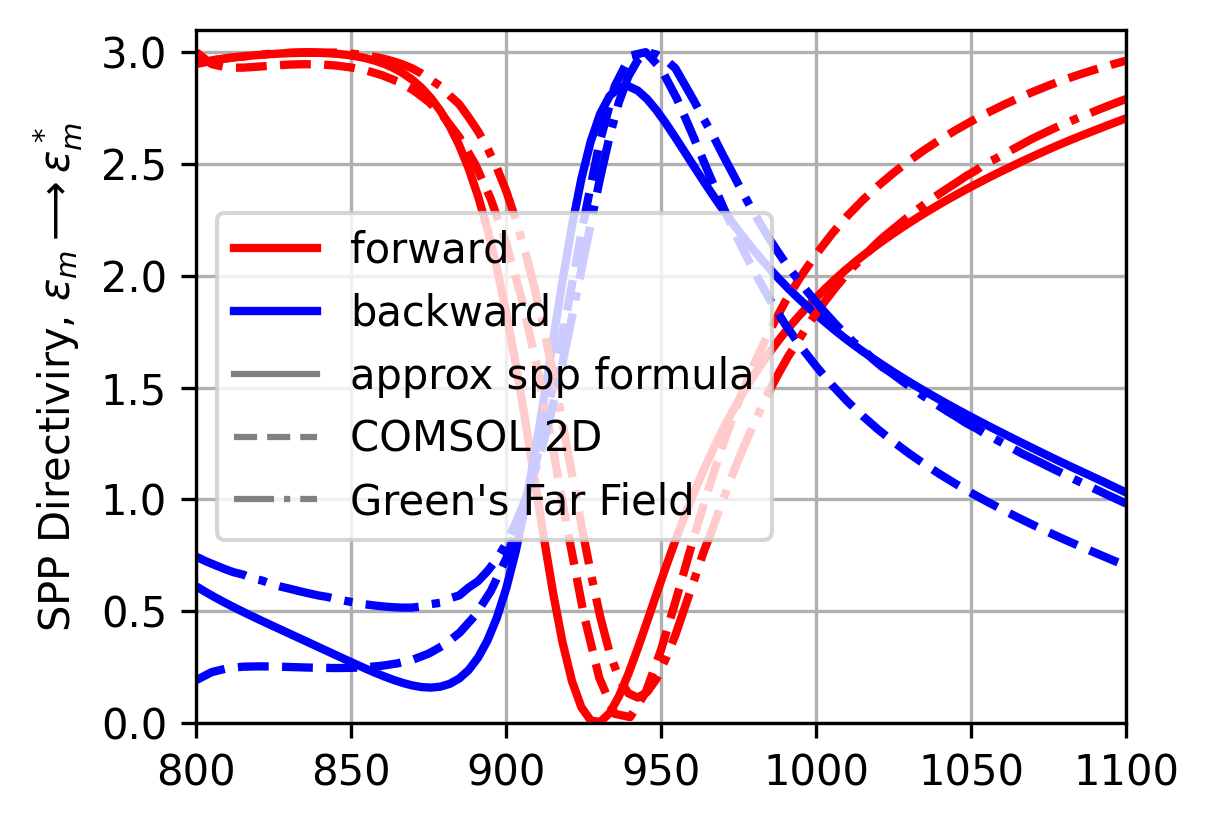

In [97]:
plt.figure(figsize=(4,3), dpi=300)
plt.plot(wls, fwd, label='forward', c='r', lw=2)
plt.plot(wls, bwd, label='backward', c='b', lw=2)

plt.plot(wls_hrel, I_fwd*3/np.max(I_fwd), c='r', lw=2, ls='--')
plt.plot(wls_hrel, I_bwd*3/np.max(I_bwd), c='b', lw=2, ls='--')

plt.plot(wls, I_fwd_greens*3/np.max(I_fwd_greens), c='r', lw=2, ls='-.')
plt.plot(wls, I_bwd_greens*3/np.max(I_bwd_greens), c='b', lw=2, ls='-.')


plt.plot([], [], label="approx spp formula",ls='-', c='grey')
plt.plot([], [], label="COMSOL 2D", ls='--', c='grey')
plt.plot([], [], label="Green's Far Field",ls='-.', c='grey')


plt.ylim(0,3.1)
plt.legend()
plt.grid()
plt.xlim(wls[0], wls[-1])
plt.ylabel('SPP Directiviry, $\\varepsilon_m \\longrightarrow \\varepsilon_m^*$')
#plt.savefig('spp_dir_eps_conj.pdf', bbox_inches='tight')
plt.show()

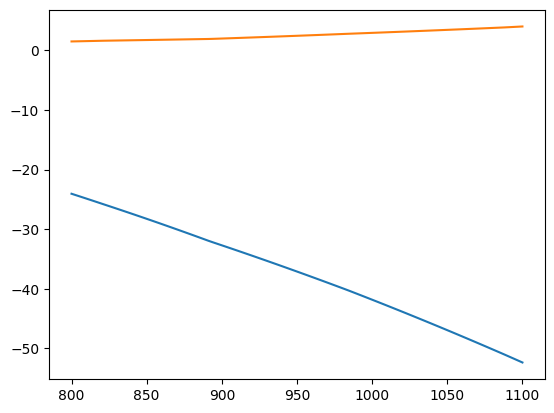

In [69]:
plt.plot(wls, eps_Au(wls).real)
plt.plot(wls, eps_Au(wls).imag)

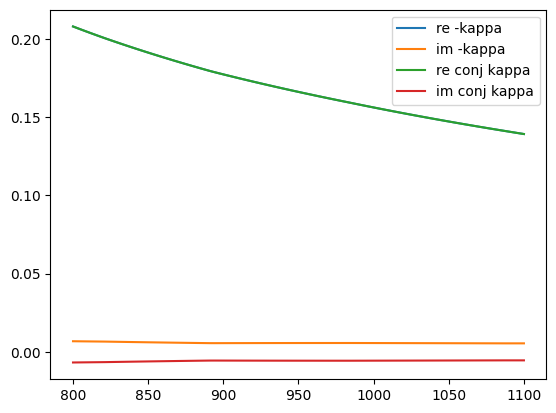

In [103]:
# plt.plot(wls, (-1j*np.sqrt(1/(eps_Au(wls)+1))).real, label='re kappa')
# plt.plot(wls, (-1j*np.sqrt(1/(eps_Au(wls)+1))).imag, label='im kappa')

plt.plot(wls, -1*(-1j*np.sqrt(1/(eps_Au(wls)+1))).real, label='re -kappa')
plt.plot(wls, -1*(-1j*np.sqrt(1/(eps_Au(wls)+1))).imag, label='im -kappa')

plt.plot(wls, (-1j*np.sqrt(1/(eps_Au(wls).conj()+1))).real, label='re conj kappa')
plt.plot(wls, (-1j*np.sqrt(1/(eps_Au(wls).conj()+1))).imag, label='im conj kappa')
plt.legend()

In [ ]:
#plt.plot(wls, -1*(-1j*np.sqrt(1/(eps_Au(wls)+1))).real, label='re -kappa')
plt.plot(wls, (1j*np.sqrt(1/(eps_Au(wls)+1))).imag, label='im -kappa')

#plt.plot(wls, (-1j*np.sqrt(1/(eps_Au(wls).conj()+1))).real, label='re conj kappa')
plt.plot(wls, np.conj((-1j*np.sqrt(1/(eps_Au(wls)+1)))).imag, label='шь conj kappa')
plt.legend()

In [135]:
F_3d = np.loadtxt('f_tm_comsol_3d.txt', skiprows=8, delimiter=',')
F_2d = np.loadtxt('f_tm_comsol_2d.txt', skiprows=8, delimiter=',')

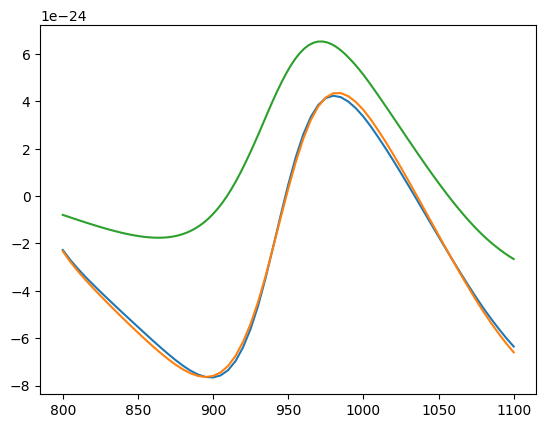

In [150]:
# plt.plot(F_3d[:,0], F_3d[:,1])
# plt.plot(F_2d[:,0], F_2d[:,1])
# plt.plot(wls, F_x[:,0])



plt.plot(F_3d[:,0], F_3d[:,3])
plt.plot(F_2d[:,0], F_2d[:,3])
plt.plot(wls, F_z[:,0])